In [4]:
import numpy as np
import pandas as pd
import os 

data = np.load('/data/hpa/colon/distance_matrices/KRT18-HPA001605.npy')
pd.DataFrame(data, columns=['healthy_image', 'pathology_image', 'c_dist'])

,healthy_image,pathology_image,c_dist
0,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.13427604111781555
1,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.19952659277219764
2,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.2194518006245444
3,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.14815780012535296
4,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.15416023314187688
5,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.17118942953138605


In [14]:
file_dir = '/data/hpa/colon/distance_matrices'
df = pd.DataFrame(columns=['healthy_image', 'pathology_image', 'c_dist'])
for cache in os.listdir(file_dir):
    data = np.load(os.path.join(file_dir, cache))
    df = df.append(pd.DataFrame(data, columns=['healthy_image', 'pathology_image', 'c_dist']))

In [12]:
df = pd.read_csv('all_inter_gene_pair_cdist.csv')

In [13]:
metadata_df = pd.read_csv('../data/colon_enhanced.csv')

In [78]:
metadata_df['subcellular_location'].unique()

array(['cytoplasmic/membranous,nuclear', 'none', 'nuclear',
       'cytoplasmic/membranous'], dtype=object)

In [55]:
#df = df.merge(metadata_df[['s3_aws_urls', 'subcellular_location']].rename(columns={'s3_aws_urls':'healthy_image', 'subcellular_location':'healthy_annotation'}), on='healthy_image')
#df = df.merge(metadata_df[['s3_aws_urls', 'subcellular_location']].rename(columns={'s3_aws_urls':'pathology_image', 'subcellular_location':'pathology_annotation'}), on='pathology_image')
df = df.merge(metadata_df[['s3_aws_urls', 'staining']].rename(columns={'s3_aws_urls':'healthy_image', 'staining':'healthy_staining'}), on='healthy_image')
df = df.merge(metadata_df[['s3_aws_urls', 'staining']].rename(columns={'s3_aws_urls':'pathology_image', 'staining':'pathology_staining'}), on='pathology_image')


In [93]:
df['expression_change'] = df.apply(lambda row: 
                                   1 if ((row['healthy_annotation']=='nuclear') & 
                                         (row['pathology_annotation']=='none')) else 0, axis=1)

In [106]:
df.groupby(['healthy_annotation','pathology_annotation']).count()

healthy_image  \
healthy_annotation             pathology_annotation                            
cytoplasmic/membranous         cytoplasmic/membranous                  48127   
                               cytoplasmic/membranous,nuclear           2616   
                               none                                    22462   
                               nuclear                                  1115   
cytoplasmic/membranous,nuclear cytoplasmic/membranous                   1803   
                               cytoplasmic/membranous,nuclear           3283   
                               none                                     1047   
                               nuclear                                  2191   
none                           cytoplasmic/membranous                   3929   
                               cytoplasmic/membranous,nuclear            237   
                               none                                    35656   
                               nuclear                                  1005   
nuclear                        cytoplasmic/membranous                    547   
                               cytoplasmic/membranous,nuclear           1583   
                               none                                     1611   
                               nuclear                                  9416   

                                                               pathology_image  \
healthy_annotation             pathology_annotation                              
cytoplasmic/membranous         cytoplasmic/membranous                    48127   
                               cytoplasmic/membranous,nuclear             2616   
                               none                                      22462   
                               nuclear                                    1115   
cytoplasmic/membranous,nuclear cytoplasmic/membranous                     1803   
                               cytoplasmic/membranous,nuclear             3283   
                               none                                       1047   
                               nuclear                                    2191   
none                           cytoplasmic/membranous                     3929   
                               cytoplasmic/membranous,nuclear              237   
                               none                                      35656   
                               nuclear                                    1005   
nuclear                        cytoplasmic/membranous                      547   
                               cytoplasmic/membranous,nuclear             1583   
                               none                                       1611   
                               nuclear                                    9416   

                                                               c_dist  \
healthy_annotation             pathology_annotation                     
cytoplasmic/membranous         cytoplasmic/membranous           48127   
                               cytoplasmic/membranous,nuclear    2616   
                               none                             22462   
                               nuclear                           1115   
cytoplasmic/membranous,nuclear cytoplasmic/membranous            1803   
                               cytoplasmic/membranous,nuclear    3283   
                               none                              1047   
                               nuclear                           2191   
none                           cytoplasmic/membranous            3929   
                               cytoplasmic/membranous,nuclear     237   
                               none                             35656   
                               nuclear                           1005   
nuclear                        cytoplasmic/membranous             547   
                               cytoplasmic/membran

In [35]:
df.to_csv('all_inter_gene_pair_cdist.csv', index=False)

In [61]:
df['staining_change'] = df.apply(lambda row: 1 if row['healthy_staining'].lower()!=row['pathology_staining'].lower() else 0, axis=1)

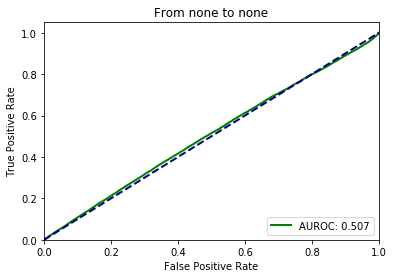

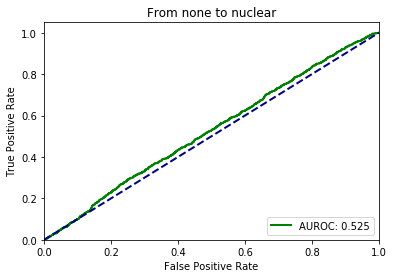

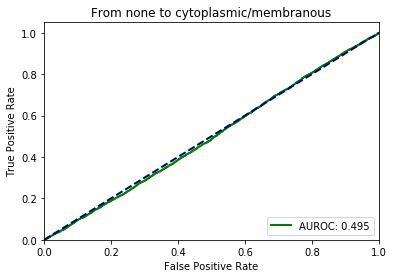

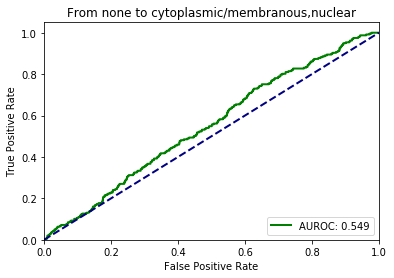

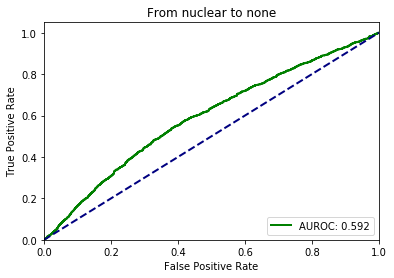

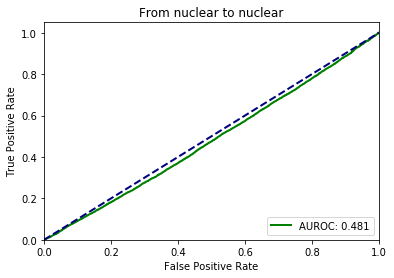

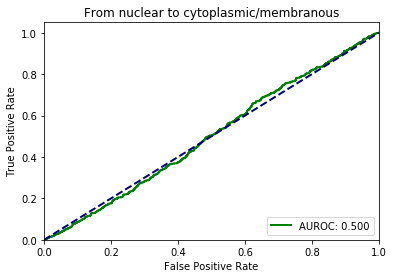

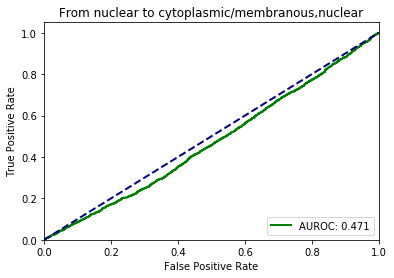

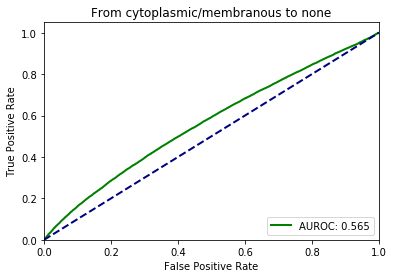

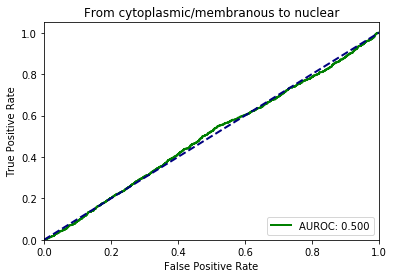

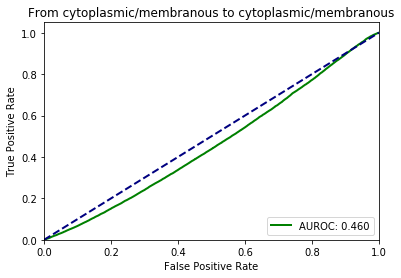

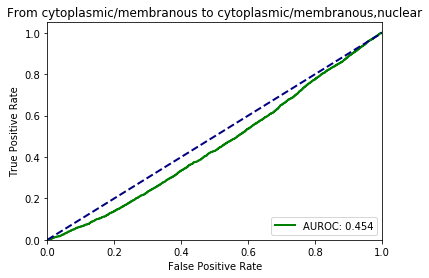

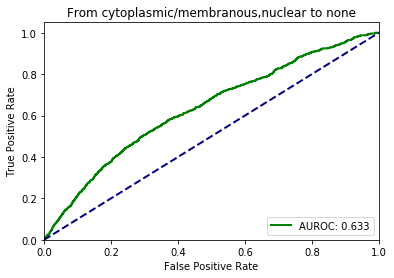

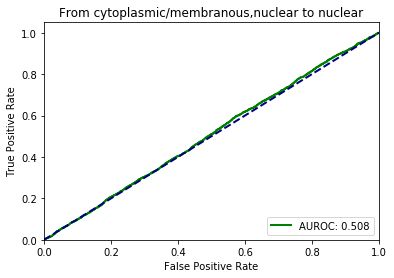

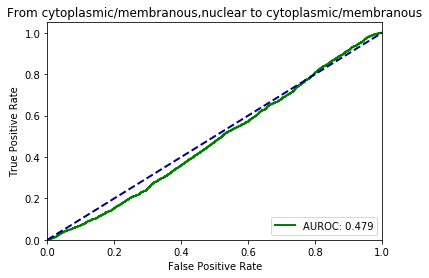

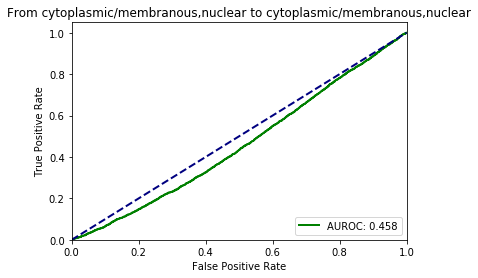

In [96]:
hpa_annotation = ['none', 'nuclear', 'cytoplasmic/membranous', 'cytoplasmic/membranous,nuclear']
for original in hpa_annotation:
    for new in hpa_annotation:
        df['expression_change'] = df.apply(lambda row: 1 if ((row['healthy_annotation']==original) & 
                                         (row['pathology_annotation']==new)) else 0, axis=1)
        plot_roc_curve(df['expression_change'], df['c_dist'], 'From {} to {}'.format(original, new))

In [95]:
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, precision_recall_curve


def plot_roc_curve(y_true, y_pred, title):
    plt.figure()
    lw=2
    fpr, tpr, thresh = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, color='green', lw=lw, label='AUROC: {:0.3f}'.format(auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

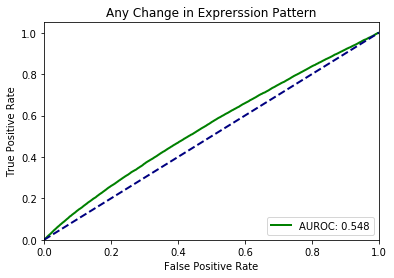

In [98]:
df['expression_change'] = df.apply(lambda row: 1 if row['healthy_annotation']!=row['pathology_annotation'] else 0, axis=1)
plot_roc_curve(df['expression_change'], df['c_dist'], 'Any Change in Exprerssion Pattern')